## Importing the libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


In [6]:
# import pathlib
# pathlib.Path().resolve()
os.getcwd()+'/Datasets/Breastcancer.csv'

'/Users/mustafamohammadi/Documents/PhD Education/Machine learning and pattern recognitions/Comp_8740/Assignment_3/Datasets/Breastcancer.csv'

In [7]:
dataset = pd.read_csv(os.getcwd()+'/Datasets/Breastcancer.csv')
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [8]:
dataset.shape

(158, 13583)

## Taking care of missing data

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X[:, :-1])
X[:, :-1] = imputer.transform(X[:, :-1])

In [10]:
print(X)

[[ 0.425 -0.316  0.465 ...  0.323 -0.4    0.064]
 [ 0.694 -0.497  0.2   ...  0.505 -0.275  0.3  ]
 [ 0.304 -0.205  0.739 ...  0.047 -0.98   0.233]
 ...
 [ 0.041  0.038  0.774 ...  0.298 -0.679  0.099]
 [ 0.139 -0.353  0.643 ... -0.144 -0.467  0.344]
 [-0.04   0.01   1.086 ...  1.654 -1.363  0.28 ]]


### Encoding the Dependent Variable

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [12]:
print(y)
y.shape

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4]


(158,)

### Min-Max scaling

In [17]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X)
X_train_minmax.max()

1.0000000000000002

### Chi-square feature selection
select two feature selections the chi_squard and the information gain

In [31]:
from sklearn.feature_selection import chi2, mutual_info_classif
chi_scores = chi2(X_train_minmax,y)
information_gain = mutual_info_classif(X_train_minmax, y)
print(chi_scores)
print(information_gain)

(array([0.56288441, 0.36218066, 0.54701439, ..., 0.54502882, 0.82407793,
       0.06101989]), array([0.96709743, 0.98545451, 0.96876566, ..., 0.96897195, 0.93519124,
       0.99954393]))
[0.03148527 0.01665064 0.         ... 0.04816028 0.07600208 0.        ]


In [30]:
print(chi_scores[0].max())
print(information_gain.max())

22.48944639060302
0.693866925355265


In [32]:
X = dataset.drop('Class',axis=1)
y = dataset['Class']
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values_IG = pd.Series(information_gain, index = X.columns)
p_values_IG.sort_values(ascending = False, inplace= True)

In [13]:
print(y)

0       Basal
1       Basal
2       Basal
3       Basal
4       Basal
        ...  
153    Normal
154    Normal
155    Normal
156    Normal
157    Normal
Name: Class, Length: 158, dtype: object


<AxesSubplot:>

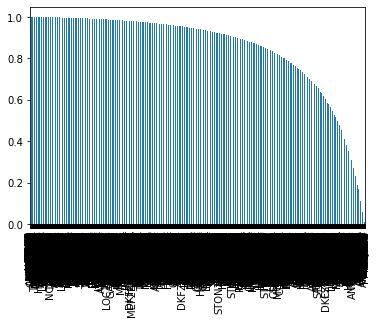

In [33]:
p_values.plot.bar()
# This will take time to run, so be patient or comment it out as it's just a graph

<AxesSubplot:>

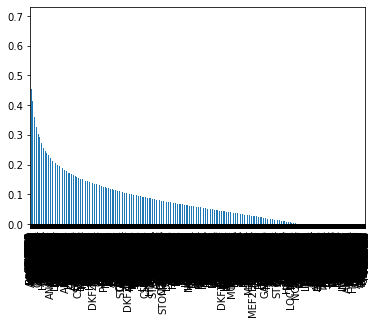

In [34]:
p_values_IG.plot.bar()

In [36]:
from sklearn.feature_selection import SelectKBest

In [37]:
chi2_selector = SelectKBest(chi2, k=500)
X_kbest = chi2_selector.fit_transform(X_train_minmax, y)

IG_selector = SelectKBest(mutual_info_classif, k=500)
X_kbest_IG = IG_selector.fit_transform(X_train_minmax, y)

print(X_kbest)
print(X_kbest_IG)

[[0.15244293 0.70728291 0.15461672 ... 0.21867928 0.16934932 0.02485236]
 [0.09867719 0.49789916 0.13937282 ... 0.22155935 0.09434932 0.22834646]
 [0.08118199 0.92950514 0.2158101  ... 0.29623534 0.14537671 0.30573327]
 ...
 [0.59409004 0.86741363 0.42857143 ... 0.29993828 0.48202055 0.83304626]
 [0.37177299 0.36671335 0.50261324 ... 0.25097717 0.4744863  0.94291339]
 [0.41263068 0.67553688 0.41093206 ... 0.34211068 0.50325342 0.95607776]]
[[0.15244293 0.70728291 0.2555399  ... 0.02029447 0.16934932 0.64151612]
 [0.09867719 0.49789916 0.25054438 ... 0.53243136 0.09434932 0.69659936]
 [0.08118199 0.92950514 0.21929038 ... 0.53521687 0.14537671 0.5214311 ]
 ...
 [0.59409004 0.86741363 0.35749968 ... 0.30362117 0.48202055 0.65161176]
 [0.37177299 0.36671335 0.57794287 ... 0.11619578 0.4744863  0.62256465]
 [0.41263068 0.67553688 0.17983861 ... 0.31078392 0.50325342 0.5524265 ]]


In [46]:
print('Original number of features:', X.shape)
print('Reduced number of features:', X_kbest.shape)

Original number of features: (158, 13582)
Reduced number of features: (158, 500)


### SVM with rbf kernel

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size = 0.2, random_state = 42)
X_train_IG, X_test_IG, y_train_IG, y_test_IG = train_test_split(X_kbest_IG, y, test_size = 0.2, random_state = 42)

In [39]:
print(y_test.unique())
print(y_test_IG.unique())


['LumB' 'Her2' 'Normal' 'LumA' 'Basal']
['LumB' 'Her2' 'Normal' 'LumA' 'Basal']


In [41]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 42, decision_function_shape='ovr')
classifier.fit(X_train, y_train)

classifier_IG = SVC(kernel = 'rbf', random_state = 42, decision_function_shape='ovr')
classifier_IG.fit(X_train_IG, y_train_IG)


SVC(random_state=42)

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

y_pred_IG = classifier.predict(X_test_IG)
cm_IG = confusion_matrix(y_test_IG, y_pred_IG)
print(cm_IG)

[[9 0 0 0 0]
 [0 3 0 0 0]
 [0 0 9 0 1]
 [0 0 2 4 0]
 [0 2 0 0 2]]
[[7 0 0 2 0]
 [0 1 1 1 0]
 [0 0 9 1 0]
 [0 0 4 2 0]
 [0 1 1 2 0]]


### 10-fold cross validation

In [44]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

accuracie_IG = cross_val_score(estimator = classifier, X = X_train_IG, y = y_train_IG, cv = 10)
print("IG Accuracy: {:.2f} %".format(accuracie_IG.mean()*100))
print("IG Standard Deviation: {:.2f} %".format(accuracie_IG.std()*100))

Accuracy: 88.72 %
Standard Deviation: 7.68 %
IG Accuracy: 87.18 %
IG Standard Deviation: 6.59 %


/opt/homebrew/Caskroom/miniforge/base/envs/tensor-metal/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tensor-metal/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


### Metrics calculation

In [45]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(FP)
print(FN)
print(TP)
print(TN)

FP_IG = cm_IG.sum(axis=0) - np.diag(cm_IG)  
FN_IG = cm_IG.sum(axis=1) - np.diag(cm_IG)
TP_IG = np.diag(cm_IG)
TN_IG = cm_IG.sum() - (FP + FN + TP)

print(FP_IG)
print(FN_IG)
print(TP_IG)
print(TN_IG)


[0 2 2 0 1]
[0 0 1 2 2]
[9 3 9 4 2]
[23 27 20 26 27]
[0 1 6 6 0]
[2 2 1 4 4]
[7 1 9 2 0]
[23 27 20 26 27]


In [48]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)


# Sensitivity, hit rate, recall, or true positive rate
TPR_IG = TP_IG/(TP_IG+FN_IG)
# Specificity or true negative rate
TNR_IG = TN_IG/(TN_IG+FP_IG) 
# Precision or positive predictive value
PPV_IG = TP_IG/(TP+FP_IG)
# Negative predictive value
NPV_IG = TN_IG/(TN_IG+FN_IG)
# Fall out or false positive rate
FPR_IG = FP_IG/(FP_IG+TN_IG)
# False negative rate
FNR_IG = FN_IG/(TP_IG+FN_IG)
# False discovery rate
FDR_IG = FP_IG/(TP_IG+FP_IG)

# Overall accuracy
ACC_IG = (TP_IG+TN_IG)/(TP_IG+FP_IG+FN_IG+TN_IG)


/var/folders/s4/mxcwk6cn2rx5fs761lbtp9zh0000gn/T/ipykernel_35196/1211481786.py:33: RuntimeWarning: invalid value encountered in true_divide
  FDR_IG = FP_IG/(TP_IG+FP_IG)


In [50]:
print("PPV:{}\nNPV:{}\nSensitivity:{}\nSpecificity:{}".format(PPV, NPV, TPR, TNR))
print('\n')
print("Accuracy:",ACC)

print("\n\n\nPPV_IG:{}\nNPV_IG:{}\nSensitivity_IG:{}\nSpecificity_IG:{}".format(PPV_IG, NPV_IG, TPR_IG, TNR_IG))
print('\n')
print("Accuracy_IG:",ACC_IG)

PPV:[1.         0.6        0.81818182 1.         0.66666667]
NPV:[1.         1.         0.95238095 0.92857143 0.93103448]
Sensitivity:[1.         1.         0.9        0.66666667 0.5       ]
Specificity:[1.         0.93103448 0.90909091 1.         0.96428571]


Accuracy: [1.      0.9375  0.90625 0.9375  0.90625]



PPV_IG:[0.77777778 0.25       0.6        0.2        0.        ]
NPV_IG:[0.92       0.93103448 0.95238095 0.86666667 0.87096774]
Sensitivity_IG:[0.77777778 0.33333333 0.9        0.33333333 0.        ]
Specificity_IG:[1.         0.96428571 0.76923077 0.8125     1.        ]


Accuracy_IG: [0.9375     0.90322581 0.80555556 0.73684211 0.87096774]


In [53]:
avg_PPV  = np.average(PPV, axis=None, weights=None, returned=False)
avg_NPV  = np.average(NPV, axis=None, weights=None, returned=False)
avg_TPR  = np.average(TPR, axis=None, weights=None, returned=False)
avg_TNR  = np.average(TNR, axis=None, weights=None, returned=False)
avg_ACC  = np.average(ACC, axis=None, weights=None, returned=False)
print("PPV:{:.2f}\nNPV:{:.2f}\nSensitivity:{:.2f}\nSpecificity:{:.2f}\nAccuracy:{:.2f}".format(avg_PPV, avg_NPV, avg_TPR, avg_TNR, avg_ACC))

avg_PPV_IG  = np.average(PPV_IG, axis=None, weights=None, returned=False)
avg_NPV_IG  = np.average(NPV_IG, axis=None, weights=None, returned=False)
avg_TPR_IG  = np.average(TPR_IG, axis=None, weights=None, returned=False)
avg_TNR_IG  = np.average(TNR_IG, axis=None, weights=None, returned=False)
avg_ACC_IG  = np.average(ACC_IG, axis=None, weights=None, returned=False)
print("\nPPV:{:.2f}\nNPV:{:.2f}\nSensitivity:{:.2f}\nSpecificity:{:.2f}\nAccuracy:{:.2f}".format(avg_PPV_IG, avg_NPV_IG, avg_TPR_IG, avg_TNR_IG, avg_ACC_IG))

PPV:0.82
NPV:0.96
Sensitivity:0.81
Specificity:0.96
Accuracy:0.94

PPV:0.37
NPV:0.91
Sensitivity:0.47
Specificity:0.91
Accuracy:0.85
